# universal estimator-exp-1b (gaussian sampling)

Let $f(d)$ be a one dimensional function, that returns a samples drawn from a univariate distribution (e.g., log-normal).

**Research question**: Let $e = (\vec{pred\_params} - \vec{test\_params})$.  
Does $STD(e)$ decreases when the parameter-search-space gets smaller?

1. Generate a sample (256 observations) using $f$ e.g: $sample = f(d=0.92, size=256)$
2. $estimator(f, sample)$ is a function which learns the parameter $d$ of $f$ from the sample.

> - Init: search_space = [0, 1]
>
> - Iterate:
>   1. Generate synthetic data-set ( train / test ) using $f(d)$ with two settings (exp-1a, exp-1b):
>          d ~ uniform(search_space)
>          d ~ norm(search_space)
>   2. Fit a DNN model to the training set
>          e = (pred_params - test_params)
>          sigma = STD(e)
>   3. Predict the parameter $d\_pred$ on the input sample using the DNN model
>          d_pred = model.predict(sample)
>   4. Narrow the search space:
>          pivot = d_pred
>          scale = 3 * std(e)
>          search_space = [ pivot - scale, pivot + scale ]
>          if next_search_space == search_space: narrow the search_space by epsilon = 0.003
>          (here I'm interested merely on narrowing the search_space, not on "correct" focusing)
>   5. Stop when either one of the following:
>      - search-space-width < 1/128 * initial-search-space-width [0, 1]
>      - std(e) <= 0.005

> - Return:
>   - d_pred_array: array of d_pred predicted at each iteration (3)
>   - search_spaces: array of search-space at each iteration (4)
>   - (pred-set, test-set) at each iteration

3. Plot a graph:

>   - $x$: iteration #
>   - $y1$: sigma_1 = STD(pred_params - test_params)
>   - $y2$: abs(d_pred - d_true)
>
> Plot (shaded) intervals around sigma_1:
>
> - sigma_2:
>          mu = mean(e)
>          var_2 = 1/n * sum( ( (e - mu) ^ 2 - (sigma_1) ^ 2 ) ^ 2 )
>          sigma_2 = sqrt(var_2)
>
> - 3 * sigma_1

**Results**:

The experiment was run on a true parameter: $d\_true =$ 0.92  
As can be shown by the plot:
> 1. sigma_1 DOES NOT decrease as we narrow the search-space.
> 2. The model predictions (pred_params) in the last iteration are out of the (narrowest) search.

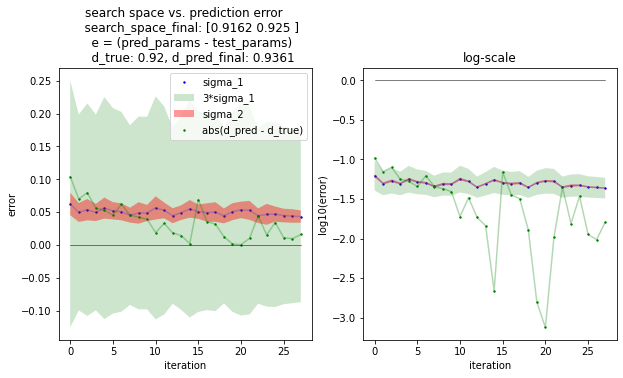

In [1]:
# import library
%run lib.ipynb
np.set_printoptions(precision=4)

In [2]:
from scipy import stats
from scipy.stats import lognorm
from scipy.stats import yulesimon

# sample from lognormal
def sample_lognormal(config, size):
    return lognorm.rvs(s=config, size=size, random_state=RANDOM_STATE)

# sample from yulesimon
def sample_yulesimon(config, size):
    return yulesimon.rvs(alpha=config, size=size, random_state=RANDOM_STATE)

def next_config(search_space, loc=-1, scale=-1):

    """
    return a (uniform/normal) random parameter within search_space
    """
    low = search_space[0]
    high = search_space[1]
    if loc < 0:
        return np.random.uniform(low, high, size=1)[0]
    
    param = np.random.normal(loc=loc, scale=scale, size=1)[0]

    # adjust from left
    param_adjusted = max(search_space[0], param)
    param_adjusted = max(0.01, param)
    
    # adjust from right
    param_adjusted = min(param_adjusted, search_space[1])
    
    return param_adjusted

In [3]:
# def MAE(e, axis=-1):
#     """mean absolute error"""
#     return np.mean(np.abs(e), axis=axis)

NUM_BINS = 346

def predict_d(f, sample, d_true, search_space, num_trials=1, N=1000, search_pivot=-1, search_scale=-1):
    
    """
    Learn parameters of f, from sample.
    Arguments:
        - f: one dimensional function that gives the PMF of a univariate distribution.
        - sample: generated using f.
    """

    # number of observations in sample
    M = len(sample)
    N = N

    nbins = NUM_BINS
    
    # Generate a histogram for the input *sample*
    H_sample = np.histogram(sample, bins=nbins, range=(0,nbins), density=False)[0]
    H_sample = np.reshape(H_sample, (1, -1))
    
    # Iterate   
    d_pred_array = np.zeros(num_trials)
    for trial_idx in range(num_trials):

        # 1. Generate synthetic data-sets (train/test) using f (within search_space)
        # -----------------------------------------------------------------------------------------------
        print()
        print(f'search_space: {search_space} - trial ({trial_idx+1}/{num_trials})')
        print(f'generating data (M={M}, N={N})', end=', ')

        raw, H, params = generate_data(N=N, 
                                       M=M, 
                                       sample=f, 
                                       nextConfig=lambda: next_config(
                                           search_space, 
                                           loc=search_pivot, 
                                           scale=search_scale),
                                       nbins=nbins,
                                       density=False, 
                                       apply_log_scale=False)

        H_train, H_test, train_params, test_params = train_test_split(H, 
                                                                      params, 
                                                                      test_size=0.25, 
                                                                      random_state=RANDOM_STATE)

        # 2. Fit a DNN model to train-set and predict on test-set
        # -----------------------------------------------------------------------------------------------

        # train
        print(f'training ...', end=' ')
        dnn_model, history = dnn_fit(X_train=H_train, y_train=train_params)

        # predict test
        pred_params = dnn_model.predict(H_test).flatten()

        # error
        e = pred_params - test_params

        # 3. Predict the parameter (d_pred) on the input sample
        # -----------------------------------------------------------------------------------------------

        d_pred = dnn_model.predict(H_sample).flatten()[0]
        d_pred_array[trial_idx] = d_pred
        
        print(f'STD(test): {np.std(e):.4f}', end=', ')
        print(f'd_pred: {d_pred:.4f}', end='')
        if len(d_pred_array) > 1:
            print(f', avg(d_pred): {np.mean(d_pred_array[:trial_idx+1]):.4f}')
        else:
            print()

    return d_pred_array, test_params, pred_params

In [4]:
def estimator_exp_1(f, sample, d_true, initial_search_space):

    # experiment results
    res = {
        'search_space': [],
        'test_params': [],
        'pred_params': [],
        'd_true': d_true,
        'd_pred': [],
    }

    initial_search_space_width = initial_search_space[1] - initial_search_space[0]
    search_space = initial_search_space
    
    # Iterate
    it = 0
    search_pivot = -1
    search_scale = -1
    
    while True:
        
        it += 1
        
        num_trials = 1
        
        d_pred_array, test_params, pred_params = predict_d(f, 
                                                           sample, 
                                                           d_true, 
                                                           search_space, 
                                                           num_trials=num_trials, 
                                                           N=1000, 
                                                           search_pivot=search_pivot, 
                                                           search_scale=search_scale)
#                                                            search_pivot=-1, 
#                                                            search_scale=-1)
        
        d_pred = np.mean(d_pred_array)

        print()
        if len(d_pred_array) > 1:
            print(f'*** avg(d_pred): {d_pred:.4f}', end=', ')
        else:
            print(f'*** d_pred: {d_pred:.4f}', end=', ')
        print(f'abs_error: {abs(d_pred - d_true):.4f}')
        
        # save results
        res['search_space'].append(search_space)
        res['test_params'].append(test_params)
        res['pred_params'].append(pred_params)
        res['d_pred'].append(d_pred)
        
        # update the search_space
        # ------------------------

        search_pivot = d_pred
        search_STD = np.std(pred_params - test_params)

#         std_factor = 1
#         std_factor = 2
        std_factor = 3

        search_scale = std_factor * search_STD
        print(f'search_pivot: {search_pivot:.4f}, search_scale ({std_factor}*STD) = {search_scale:.4f}')
        
        next_search_space = np.array([ 
            max(search_space[0], search_pivot - search_scale), 
            min(search_space[1], search_pivot + search_scale)])
        
        # if no change in search_space, narrow by epsilon
        if np.array_equal(search_space, next_search_space):
            epsilon = 0.003
            print(f'no change in search_space. narrowing by epsilon: {epsilon:.4f}')
            search_space = np.array([search_space[0] + epsilon, search_space[1] - epsilon])
        else:
            search_space = next_search_space
        
        # stop condition: size of the search-space (high-low) is 1/128 of the original
        search_space_width = search_space[1] - search_space[0]
        search_space_shrink_factor = 1/128
        if search_space_width < search_space_shrink_factor * initial_search_space_width:
            break

        # stop condition (2): search_STD <=0.01
        if search_STD <= 0.001:
            break

    res['search_space'] = np.array(res['search_space'])
    res['test_params'] = np.array(res['test_params'])
    res['pred_params'] = np.array(res['pred_params'])
    res['d_pred'] = np.array(res['d_pred'])
    
    return res

## Plot

In [5]:
def plot_search_space_size_vs_d_pred_error(res):

    search_space = res['search_space']
    search_space_width = search_space[:,1] - search_space[:,0]
    search_space_final = search_space[-1]
    
    d_true = res['d_true']
    d_pred = res['d_pred']
    d_pred_final = d_pred[-1] # d_pred of the last (narrowest) search_space
    d_pred_abs_error = np.abs(d_pred - d_true)

    pred_params = res['pred_params']
    test_params = res['test_params']

    # errors in each iteration
    e = pred_params - test_params
    
    # num-iterations
    n = e.shape[0]
    
    # avg error of each iteration
    mu = np.mean(e, axis=1).reshape((n,-1))
    
    # STD in each iteration
    sigma_1 = np.std(e, axis=1)

    # sigma_2
    mu = np.mean(e, axis=1).reshape(n, 1)
    var_2 = 1/n * np.sum(np.square(np.square(e - mu) - np.square(sigma_1).reshape(n,1)), axis=1)
    sigma_2 = np.sqrt(var_2)

    # iteration number
    x = np.array(range(n))
    
    # PLOT
    title = f'search space vs. prediction error \n\
    search_space_final: {search_space_final} \n\
    e = (pred_params - test_params) \n\
    d_true: {d_true}, d_pred_final: {d_pred_final:.4f}'
    
    fig, axes  = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    
    for ax in axes:

        # zero reference line
        ax.plot(x, np.zeros(n), zorder=2, c='black', linewidth=0.5)

        ax.set_xlabel('iteration')
        
        if ax == axes[0]:
            ax.set_title(title)
            y1 = sigma_1
            y2 = d_pred_abs_error
            ax.set_ylabel('error')
        else:
            ax.set_title('log-scale')
            y1 = np.log10(y1)
            y2 = np.log10(y2)
            ax.set_ylabel('log10(error)')

        ax.scatter(x, y1, zorder=1, s=2, c='blue', label='sigma_1')
        ax.plot(x, y1, zorder=2, c='blue', alpha=0.2)
        
        # confidence_interval_1: sigma_1 +- 3*sigma_1
        ax.fill_between(range(len(x)), 
                         y1 - 3*sigma_1, y1 + 3*sigma_1, 
                         facecolor='green', alpha=0.2, label='3*sigma_1')

        # confidence_interval_2: sigma_1 +- sigma_2
        ax.fill_between(range(len(x)), 
                         y1 - sigma_2, y1 + sigma_2, 
                         facecolor='red', alpha=0.4, label='sigma_2')

        # y2 (d_pred)
        ax.scatter(x, y2, zorder=1, s=2, c='green', label='abs(d_pred - d_true)')
        ax.plot(x, y2, zorder=2, c='green', alpha=0.3)
    
        if ax == axes[0]:
            ax.legend(loc='upper right')
            
    plt.show()

## Fit (lognormal)


param true value: 0.92

search_space: [0. 1.] - trial (1/1)
generating data (M=256, N=1000), training ... STD(test): 0.0626, d_pred: 1.0241

*** d_pred: 1.0241, abs_error: 0.1041
search_pivot: 1.0241, search_scale (3*STD) = 0.1879

search_space: [0.8361 1.    ] - trial (1/1)
generating data (M=256, N=1000), training ... STD(test): 0.0496, d_pred: 0.9901

*** d_pred: 0.9901, abs_error: 0.0701
search_pivot: 0.9901, search_scale (3*STD) = 0.1489

search_space: [0.8412 1.    ] - trial (1/1)
generating data (M=256, N=1000), training ... STD(test): 0.0539, d_pred: 0.9996

*** d_pred: 0.9996, abs_error: 0.0796
search_pivot: 0.9996, search_scale (3*STD) = 0.1617
no change in search_space. narrowing by epsilon: 0.0030

search_space: [0.8442 0.997 ] - trial (1/1)
generating data (M=256, N=1000), training ... STD(test): 0.0496, d_pred: 0.9762

*** d_pred: 0.9762, abs_error: 0.0562
search_pivot: 0.9762, search_scale (3*STD) = 0.1489
no change in search_space. narrowing by epsilon: 0.0030

search_

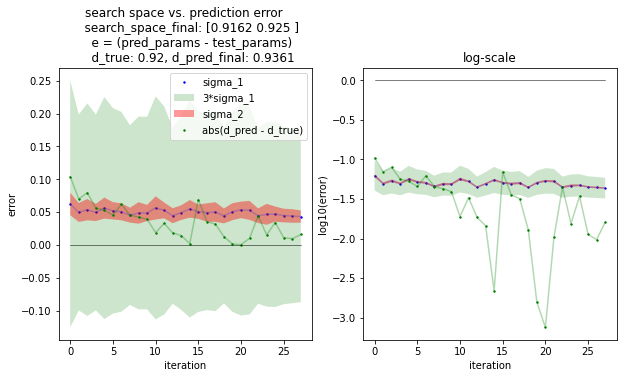

In [6]:
d_true = 0.92
print()
print(f'param true value: {d_true}')
f = sample_lognormal
sample = f(config=d_true, size=256)
initial_search_space=np.array([0.0, 1.0])
res = estimator_exp_1(f=f, sample=sample, d_true=d_true, initial_search_space=initial_search_space)
plot_search_space_size_vs_d_pred_error(res)

In [10]:
# np.abs(res['pred_params'][-1] - res['test_params'][-1])
res['pred_params'][-1]

array([0.8993, 0.8095, 0.9517, 0.8373, 0.9313, 0.8635, 0.8682, 0.9157,
       0.7621, 0.9063, 0.7607, 0.8484, 0.8684, 0.9252, 0.9151, 0.8094,
       0.8165, 0.8161, 0.8547, 0.9161, 0.9251, 0.9072, 0.8799, 0.9236,
       0.8404, 0.9311, 0.8161, 0.8811, 0.8724, 0.8621, 0.9268, 0.8659,
       0.9215, 0.9232, 0.9277, 0.9074, 0.9267, 0.8918, 0.8854, 0.895 ,
       0.9339, 0.9225, 0.8208, 0.7021, 0.8445, 0.9132, 0.9151, 0.908 ,
       0.9158, 0.8865, 0.8787, 0.8963, 0.9267, 0.9304, 0.8997, 0.8537,
       0.9213, 0.8857, 0.9142, 0.9494, 0.9053, 0.9444, 0.8945, 0.9233,
       0.9076, 0.9295, 0.7579, 0.8576, 0.949 , 0.908 , 0.8059, 0.8706,
       0.8916, 0.9317, 0.9084, 0.933 , 0.9188, 0.9312, 0.8718, 0.9285,
       0.6582, 0.8728, 0.8925, 0.8914, 0.8756, 0.891 , 0.9004, 0.8379,
       0.9119, 0.9096, 0.9283, 0.7572, 0.9144, 0.9384, 0.8479, 0.8849,
       0.906 , 0.8871, 0.8328, 0.9224, 0.7641, 0.9225, 0.879 , 0.908 ,
       0.9396, 0.8094, 0.8731, 0.7724, 0.9202, 0.9068, 0.9298, 0.9177,
      